In [2]:
cd ..

/home/wesg/research/neuron-stats


In [3]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import pickle
import argparse
import einops
import torch
import numpy as np
import pandas as pd
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import torch

torch.set_grad_enabled(False)

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
tdf = pd.read_csv('dataframes/vocab_dfs/gpt2_topics.csv')

In [5]:
tdf

,token_str,is_empire_topic,is_name_topic,is_cooking_topic,is_dialogue_topic,is_academics_topic,is_military_topic,is_biotech_topic,is_computer_programming_topic,is_capitalized_topic,...,is_nutrition_topic,is_astronomy_topic,is_HIV/AIDS_topic,is_audio_topic,is_storytelling_topic,is_research_topic,is_politics_topic,is_government_topic,is_Spanish_topic,is_chemistry_topic
0,!,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"""",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,#,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,$,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,%,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50252,regress,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
50253,Collider,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
50254,informants,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
50255,gazed,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
for column in tdf.columns[1:]:
    column_toks = tdf[tdf[column]].token_str.values
    print(column, len(column_toks), column_toks[:3])

is_empire_topic 110 ['ians' ' King' ' profess']
is_name_topic 79 ['acks' 'ogue' ' Chris']
is_cooking_topic 430 [' �' 'akes' 'ield']
is_dialogue_topic 94 ['ently' ".'" 'aming']
is_academics_topic 30 ['–' ' Press' ' Journal']
is_military_topic 39 [' War' ' Republic' ' South']
is_biotech_topic 97 ['ated' ' were' ' min']
is_computer_programming_topic 33 ['�' '�' '�']
is_capitalized_topic 120 ['ribut' ' IN' ' OF']
is_contract_topic 43 [' �' ' any' ' under']
is_French_topic 130 [' le' 'ans' 'ous']
is_software_topic 39 ['<' 'vil' 'eless']
is_body_topic 29 ['�' '�' '�']
is_Japanese_topic 135 ['�' '�' '�']
is_nature_topic 7 [' wood' ' flowers' ' forests']
is_pop_culture_topic 54 [' music' ' song' ' tour']
is_education_topic 78 [' school' ' social' ' experience']
is_program/script_topic 19 ['works' 'map' 'rator']
is_finance_topic 117 ['�' '�' '�']
is_business/economics_topic 151 [' year' ' its' ' month']
is_number_topic 67 ['240' ' 210' ' 270']
is_Portuguese_topic 151 ['�' '�' '�']
is_optics_top

In [7]:
(11 * 24) / 128

2.0625

In [8]:
examples = {
    (9, 3430): ['demand', 'require', 'obligation'],
    (6, 3057): ['surnames', 'comma after surname'],
    (6, 2158): ['period after abbreviation'],
    (17, 2896): ['Canada'],
    (17, 944): ['Japan'],
}

In [9]:
from summary_viewer import *


In [10]:
model_name = 'stanford-gpt2-medium-a'
tokenizer, decoded_vocab = get_tokenizer_and_decoded_vocab(model_name)
dataset_summaries = load_all_summaries(model_name)


Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-medium-a into HookedTransformer


In [11]:
dataset_summaries.keys()

dict_keys(['arxiv', 'bookcorpus2', 'books3', 'dm_mathematics', 'enron_emails', 'europarl', 'freelaw', 'github', 'gutenberg', 'hackernews', 'nih_exporter', 'opensubtitles', 'openwebtext2', 'philpapers', 'pile_cc', 'pubmed_abstracts', 'pubmed_central', 'stackexchange', 'ubuntu_irc', 'uspto_backgrounds', 'wikipedia', 'youtubesubtitles'])

In [12]:
dataset_summaries['opensubtitles']['vocab_counts'].sum()

tensor(5886464.)

In [13]:
dataset_summaries['pile_cc']['vocab_counts'].sum()

tensor(53855232.)

In [14]:
dataset_summaries['pile_cc']['vocab_counts']

tensor([6.4123e+04, 6.1154e+04, 4.4530e+03,  ..., 4.8000e+01, 6.9000e+01,
        1.0519e+05])

In [15]:
l, n = 17, 2896
distribution = 'pile_cc'

token_ixs = dataset_summaries[distribution]['neuron_vocab_mean_ixs'][l, n].astype(int)
canada_df = pd.DataFrame({
    'token_ixs': token_ixs,
    'token_str': [decoded_vocab[t] for t in token_ixs],
    'token_val': dataset_summaries[distribution]['neuron_vocab_mean'][l, n],
    'token_count': dataset_summaries[distribution]['vocab_counts'][token_ixs]
})


In [16]:
canada_df.query('token_count > 75').head(30)

,token_ixs,token_str,token_val,token_count
4,17842,Calgary,2.746094,207.0
5,21165,Edmonton,2.652344,140.0
6,10553,Ontario,2.638672,501.0
7,5398,Canadian,2.583984,1838.0
8,6586,Toronto,2.468750,1056.0
9,14778,Quebec,2.453125,337.0
10,23434,Winnipeg,2.414062,126.0
11,14074,Ottawa,2.408203,257.0
12,31359,Toronto,2.396484,128.0
14,10930,Vancouver,2.349609,657.0


In [17]:
# japan df
l, n = 17, 944
distribution = 'pile_cc'

token_ixs = dataset_summaries[distribution]['neuron_vocab_mean_ixs'][l, n].astype(int)
japan_df = pd.DataFrame({
    'token_ixs': token_ixs,
    'token_str': [decoded_vocab[t] for t in token_ixs],
    'token_val': dataset_summaries[distribution]['neuron_vocab_mean'][l, n],
    'token_count': dataset_summaries[distribution]['vocab_counts'][token_ixs]
})
japan_df.loc[2, 'token_val'] = 2

In [18]:
# filter non english alphabetical tokens
japan_df.query('token_count > 50').loc[lambda df: df.token_str.str.match(r'\s+[a-zA-Z]+$')].head(30)

,token_ixs,token_str,token_val,token_count
2,34170,Fukushima,2.000000,73.0
11,28563,Yosh,1.858398,85.0
19,25940,Hiro,1.694336,52.0
37,4960,Japanese,1.460938,1928.0
39,29464,Miy,1.429688,77.0
43,36298,Kyoto,1.390625,72.0
45,47221,Okinawa,1.372070,79.0
48,22431,Fuk,1.351562,69.0
54,27812,Anime,1.309570,76.0
59,22424,Mits,1.290039,92.0


In [19]:
vocab = {v: k for k, v in decoded_vocab.items()}

In [20]:
vocab[' Africa'], vocab[' Nigeria'], vocab[' African'], vocab[' Kenya'], vocab[' Sudan'], vocab[' Niger']

(5478, 19398, 5510, 21506, 19610, 23731)

In [21]:
vocab[' Brazil'], vocab[' Amazon'], vocab[' Janeiro'], vocab[' Paulo']

(7595, 6186, 42799, 34410)

In [22]:
dataset_summaries['arxiv'].keys()

dict_keys(['neuron_bin_counts', 'vocab_counts', 'neuron_vocab_max', 'neuron_vocab_max_ixs', 'neuron_bin_edges', 'neuron_vocab_mean', 'neuron_vocab_mean_ixs', 'neuron_max_activating_index', 'neuron_max_activating_value'])

In [23]:
africa_tokens = set([5478, 19398, 5510, 21506, 19610, 23731])
brazil_tokens = set([7595, 6186, 42799, 34410])
# compute neuron with most africa tokens

# layer x neuron x token of top tokens
top_neuron_tokens = dataset_summaries[distribution]['neuron_vocab_mean_ixs']

overlap_count = np.isin(top_neuron_tokens, list(brazil_tokens)).sum(axis=2)


In [24]:
np.where(overlap_count == 3)

(array([ 8, 14]), array([2699, 3820]))

In [25]:
# japan df
l, n = 14, 3820
distribution = 'pile_cc'

token_ixs = dataset_summaries[distribution]['neuron_vocab_mean_ixs'][l, n].astype(int)
latin_american_df = pd.DataFrame({
    'token_ixs': token_ixs,
    'token_str': [decoded_vocab[t] for t in token_ixs],
    'token_val': dataset_summaries[distribution]['neuron_vocab_mean'][l, n],
    'token_count': dataset_summaries[distribution]['vocab_counts'][token_ixs]
})

In [26]:
k = 10
place_neurons = [(17, 2896), (17, 944), (14, 3820)]
place_dfs = [
    canada_df.query('token_count > 75').head(k), 
    japan_df.query('token_count > 50').loc[lambda df: df.token_str.str.match(r'\s+[a-zA-Z]+$')].head(k), 
    latin_american_df.query('token_count > 90').head(k)
]
place_toks = np.stack([pdf['token_str'].values for pdf in place_dfs]).T
place_values = np.stack([pdf['token_val'].values for pdf in place_dfs]).T

In [27]:
place_toks.shape

(10, 3)

AttributeError: 'Colorbar' object has no attribute 'set_label_rotation'

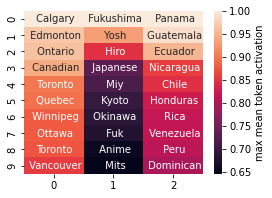

In [36]:
# seaborn heatmap with labels as top tokens and colors as values
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(place_values / place_values.max(axis=0), annot=place_toks, fmt='', cbar=True, ax=ax)

# change cbar label to "max mean token activation (normalized)"
ax.collections[0].colorbar.set_label('max mean token activation')
# rotate cbar label 180 degrees


# turn off xticks
ax.set_yticks([])
# set x ticks to neuron names
tick_labels = [f'L{l}.{n}' for l, n in place_neurons]
ax.set_xticklabels(tick_labels, rotation=0)

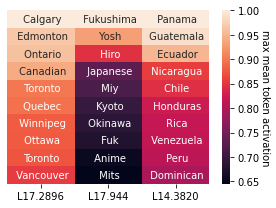

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your existing code for the heatmap
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(place_values / place_values.max(axis=0), annot=place_toks, fmt='', cbar=True, ax=ax)

# Change cbar label and rotate it 180 degrees
cbar = ax.collections[0].colorbar
cbar.set_label('max mean token activation', rotation=270, labelpad=10)

cbar_ax = cbar.ax
pos = cbar_ax.get_position()  # returns a Bbox object
# Adjust the position parameters as needed (left, bottom, width, height)
cbar_ax.set_position([pos.x0, pos.y0, pos.width, pos.height])

# Turn off y ticks
ax.set_yticks([])

# Set x ticks to neuron names
tick_labels = [f'L{l}.{n}' for l, n in place_neurons]
ax.set_xticklabels(tick_labels, rotation=0)

plt.tight_layout()

plt.savefig('figures/place_neurons.png', dpi=200, bbox_inches='tight')